# Group 1 project: Crime Data in Denver for 2015-2017

In [30]:
#Dependencies 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import datetime as dt 
import random
import matplotlib.colors
from pylab import rcParams

#dependencies for location heatmap 
from census import Census 
from config import (census_key, gkey)
import gmaps 
import requests 
import time 

#Census API Key 
c = Census(census_key, year = 2015) 

## Importing crime data and offense code csv files and merging them on offense code

In [2]:
#import crime.csv file 
#import crime.csv file
df_crime = pd.read_csv('crimedata.csv')
df_offense = pd.read_csv('offense_codes.csv')
# Group OFFENSE_CODEs by OFFENSE_CATEGORY_ID
df_offense = df_offense.drop_duplicates(subset=['OFFENSE_CODE','OFFENSE_CATEGORY_ID'])

df_crimemerge = df_crime.merge(df_offense, on='OFFENSE_CODE')

df_crimemerge.count()

INCIDENT_ID                 291167
OFFENSE_ID                  291167
OFFENSE_CODE                291167
OFFENSE_CODE_EXTENSION_x    291167
OFFENSE_TYPE_ID_x           291167
OFFENSE_CATEGORY_ID_x       291167
FIRST_OCCURRENCE_DATE       291167
LAST_OCCURRENCE_DATE         99683
REPORTED_DATE               291167
INCIDENT_ADDRESS            263384
GEO_X                       288905
GEO_Y                       288905
GEO_LON                     288905
GEO_LAT                     288905
DISTRICT_ID                 291167
PRECINCT_ID                 291167
NEIGHBORHOOD_ID             291167
IS_CRIME_x                  291167
IS_TRAFFIC_x                291167
OFFENSE_CODE_EXTENSION_y    291167
OFFENSE_TYPE_ID_y           291167
OFFENSE_TYPE_NAME           291167
OFFENSE_CATEGORY_ID_y       291167
OFFENSE_CATEGORY_NAME       291167
IS_CRIME_y                  291167
IS_TRAFFIC_y                291167
dtype: int64

## Converting date object to a date time date type and refining our data

In [4]:
# Converting 'FIRST_OCCURRENCE_DATE','LAST_OCCURRENCE_DATE','REPORTED_DATE' from object to datetime:
df_crimemerge[['FIRST_OCCURRENCE_DATE','LAST_OCCURRENCE_DATE','REPORTED_DATE']] = df_crimemerge[['FIRST_OCCURRENCE_DATE','LAST_OCCURRENCE_DATE','REPORTED_DATE']].apply(pd.to_datetime)
df_crimemerge.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION_x,OFFENSE_TYPE_ID_x,OFFENSE_CATEGORY_ID_x,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,...,NEIGHBORHOOD_ID,IS_CRIME_x,IS_TRAFFIC_x,OFFENSE_CODE_EXTENSION_y,OFFENSE_TYPE_ID_y,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_ID_y,OFFENSE_CATEGORY_NAME,IS_CRIME_y,IS_TRAFFIC_y
0,2.018427e+09,2.018430e+15,1102,0,sex-aslt-rape,sexual-assault,2015-01-01,2016-01-01 00:00:00,2018-06-26 00:33:00,NaN,...,whittier,1,0,0,sex-aslt-rape,Rape,sexual-assault,Sexual Assault,1,0
1,2.015500e+10,2.015500e+16,1102,0,sex-aslt-rape,sexual-assault,2015-01-01,NaT,2015-07-21 08:00:00,NaN,...,berkeley,1,0,0,sex-aslt-rape,Rape,sexual-assault,Sexual Assault,1,0
2,2.017304e+09,2.017300e+15,1102,0,sex-aslt-rape,sexual-assault,2015-01-01,2016-05-10 00:00:00,2017-05-10 15:14:00,NaN,...,montbello,1,0,0,sex-aslt-rape,Rape,sexual-assault,Sexual Assault,1,0
3,2.016416e+08,2.016420e+14,1102,1,sex-aslt-rape-pot,sexual-assault,2015-01-01,2016-01-13 23:59:00,2016-01-20 18:12:00,NaN,...,goldsmith,1,0,0,sex-aslt-rape,Rape,sexual-assault,Sexual Assault,1,0
4,2.018500e+10,2.018500e+16,1102,1,sex-aslt-rape-pot,sexual-assault,2015-01-01,2015-12-31 00:00:00,2018-09-26 12:17:00,NaN,...,goldsmith,1,0,0,sex-aslt-rape,Rape,sexual-assault,Sexual Assault,1,0


In [6]:
# Defining new data set by keeping only the columns we are plotting against:
df_crimemerge_refined = df_crimemerge.loc[:,["INCIDENT_ID","OFFENSE_ID","OFFENSE_CODE","OFFENSE_TYPE_ID_x","OFFENSE_CATEGORY_ID_x","FIRST_OCCURRENCE_DATE","REPORTED_DATE","INCIDENT_ADDRESS","GEO_LON","GEO_LAT","DISTRICT_ID","PRECINCT_ID","NEIGHBORHOOD_ID","IS_CRIME_x","IS_TRAFFIC_x","OFFENSE_CATEGORY_NAME"]]
df_crimemerge_refined.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_TYPE_ID_x,OFFENSE_CATEGORY_ID_x,FIRST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME_x,IS_TRAFFIC_x,OFFENSE_CATEGORY_NAME
0,2.018427e+09,2.018430e+15,1102,sex-aslt-rape,sexual-assault,2015-01-01,2018-06-26 00:33:00,NaN,NaN,NaN,2,211,whittier,1,0,Sexual Assault
1,2.015500e+10,2.015500e+16,1102,sex-aslt-rape,sexual-assault,2015-01-01,2015-07-21 08:00:00,NaN,NaN,NaN,1,111,berkeley,1,0,Sexual Assault
2,2.017304e+09,2.017300e+15,1102,sex-aslt-rape,sexual-assault,2015-01-01,2017-05-10 15:14:00,NaN,NaN,NaN,5,521,montbello,1,0,Sexual Assault
3,2.016416e+08,2.016420e+14,1102,sex-aslt-rape-pot,sexual-assault,2015-01-01,2016-01-20 18:12:00,NaN,NaN,NaN,3,323,goldsmith,1,0,Sexual Assault
4,2.018500e+10,2.018500e+16,1102,sex-aslt-rape-pot,sexual-assault,2015-01-01,2018-09-26 12:17:00,NaN,NaN,NaN,3,323,goldsmith,1,0,Sexual Assault


In [7]:
# Renamimg comlumns with _x:
df_crimemerge_refined = df_crimemerge_refined.rename(index=str , columns={"OFFENSE_TYPE_ID_x" : "OFFENSE_TYPE_ID" , "OFFENSE_CATEGORY_ID_x" : "OFFENSE_CATEGORY_ID"})
df_crimemerge_refined.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME_x,IS_TRAFFIC_x,OFFENSE_CATEGORY_NAME
0,2.018427e+09,2.018430e+15,1102,sex-aslt-rape,sexual-assault,2015-01-01,2018-06-26 00:33:00,NaN,NaN,NaN,2,211,whittier,1,0,Sexual Assault
1,2.015500e+10,2.015500e+16,1102,sex-aslt-rape,sexual-assault,2015-01-01,2015-07-21 08:00:00,NaN,NaN,NaN,1,111,berkeley,1,0,Sexual Assault
2,2.017304e+09,2.017300e+15,1102,sex-aslt-rape,sexual-assault,2015-01-01,2017-05-10 15:14:00,NaN,NaN,NaN,5,521,montbello,1,0,Sexual Assault
3,2.016416e+08,2.016420e+14,1102,sex-aslt-rape-pot,sexual-assault,2015-01-01,2016-01-20 18:12:00,NaN,NaN,NaN,3,323,goldsmith,1,0,Sexual Assault
4,2.018500e+10,2.018500e+16,1102,sex-aslt-rape-pot,sexual-assault,2015-01-01,2018-09-26 12:17:00,NaN,NaN,NaN,3,323,goldsmith,1,0,Sexual Assault


In [8]:
# Dropping all missing values for Longitude and Latitude:
df_crimemerge_refined["GEO_LON"].replace('', np.nan, inplace=True)
df_crimemerge_refined.dropna(subset=["GEO_LON"], inplace=True)

df_crimemerge_refined["GEO_LAT"].replace('', np.nan, inplace=True)
df_crimemerge_refined.dropna(subset=["GEO_LAT"], inplace=True)

df_crimemerge_refined.count()

INCIDENT_ID              288905
OFFENSE_ID               288905
OFFENSE_CODE             288905
OFFENSE_TYPE_ID          288905
OFFENSE_CATEGORY_ID      288905
FIRST_OCCURRENCE_DATE    288905
REPORTED_DATE            288905
INCIDENT_ADDRESS         263384
GEO_LON                  288905
GEO_LAT                  288905
DISTRICT_ID              288905
PRECINCT_ID              288905
NEIGHBORHOOD_ID          288905
IS_CRIME_x               288905
IS_TRAFFIC_x             288905
OFFENSE_CATEGORY_NAME    288905
dtype: int64

In [9]:
df_crimemerge_refined.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME_x,IS_TRAFFIC_x,OFFENSE_CATEGORY_NAME
1402,2.015178e+08,2.015180e+14,5309,harassment,public-disorder,2015-01-01 00:00:00,2015-01-10 12:32:00,1624 N XENIA ST,-104.885484,39.742555,2,223,east-colfax,1,0,Public Disorder
1403,2.015500e+10,2.015500e+16,5309,harassment,public-disorder,2015-01-01 12:00:00,2015-04-17 08:00:00,1331 N CHEROKEE ST,-104.992316,39.737154,6,611,civic-center,1,0,Public Disorder
1404,2.015121e+07,2.015120e+13,5309,harassment-dv,public-disorder,2015-01-01 16:53:00,2015-01-01 17:31:00,8000 E 12TH AVE,-104.896207,39.734482,2,223,east-colfax,1,0,Public Disorder
1405,2.015137e+09,2.015140e+15,5309,harassment,public-disorder,2015-01-01 16:58:00,2015-03-12 16:58:00,NaN,-104.941875,39.739207,2,213,congress-park,1,0,Public Disorder
1406,2.015216e+09,2.015220e+15,5309,harassment,public-disorder,2015-01-03 00:00:00,2015-04-20 18:08:00,3075 N ELM ST,-104.929719,39.761300,2,221,north-park-hill,1,0,Public Disorder


## Creating our bins for each year 2015-2017

In [10]:
# 2015 bin
df_15 = df_crimemerge_refined.loc[df_crimemerge_refined[str('FIRST_OCCURRENCE_DATE')] < '1/1/16 0:00']
df_15.count()
df_15['FIRST_OCCURRENCE_DATE'].describe()


count                   94139
unique                  57431
top       2015-01-01 00:00:00
freq                       20
first     2015-01-01 00:00:00
last      2015-12-31 23:50:00
Name: FIRST_OCCURRENCE_DATE, dtype: object

In [11]:
# 2016 bin
df_16 = df_crimemerge_refined.loc[(df_crimemerge_refined[str('FIRST_OCCURRENCE_DATE')] > '12/31/15 23:59') & (df_crimemerge_refined[str('FIRST_OCCURRENCE_DATE')] < '1/1/17 0:00')]
df_16.count()
df_16['FIRST_OCCURRENCE_DATE'].describe()

count                   96605
unique                  59778
top       2016-01-01 12:00:00
freq                       21
first     2016-01-01 00:00:00
last      2016-12-31 23:55:00
Name: FIRST_OCCURRENCE_DATE, dtype: object

In [12]:
# 2017 bin
df_17 = df_crimemerge_refined.loc[df_crimemerge_refined[str('FIRST_OCCURRENCE_DATE')] > '12/31/16 23:59']
df_17.count()
df_17['FIRST_OCCURRENCE_DATE'].describe()

count                   98161
unique                  62114
top       2017-01-01 00:00:00
freq                       18
first     2017-01-01 00:00:00
last      2017-12-31 23:58:00
Name: FIRST_OCCURRENCE_DATE, dtype: object

## First Plot: Number of Offenses by Category

In [13]:
offense_categories = df_crimemerge_refined.groupby('OFFENSE_CATEGORY_ID')
# offense_categories_count = offense_categories.count().astype(str)
#type(offense_categories)
offense_categories.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME_x,IS_TRAFFIC_x,OFFENSE_CATEGORY_NAME
1402,2.015178e+08,2.015180e+14,5309,harassment,public-disorder,2015-01-01 00:00:00,2015-01-10 12:32:00,1624 N XENIA ST,-104.885484,39.742555,2,223,east-colfax,1,0,Public Disorder
1403,2.015500e+10,2.015500e+16,5309,harassment,public-disorder,2015-01-01 12:00:00,2015-04-17 08:00:00,1331 N CHEROKEE ST,-104.992316,39.737154,6,611,civic-center,1,0,Public Disorder
1404,2.015121e+07,2.015120e+13,5309,harassment-dv,public-disorder,2015-01-01 16:53:00,2015-01-01 17:31:00,8000 E 12TH AVE,-104.896207,39.734482,2,223,east-colfax,1,0,Public Disorder
1405,2.015137e+09,2.015140e+15,5309,harassment,public-disorder,2015-01-01 16:58:00,2015-03-12 16:58:00,NaN,-104.941875,39.739207,2,213,congress-park,1,0,Public Disorder
1406,2.015216e+09,2.015220e+15,5309,harassment,public-disorder,2015-01-03 00:00:00,2015-04-20 18:08:00,3075 N ELM ST,-104.929719,39.761300,2,221,north-park-hill,1,0,Public Disorder
2546,2.015220e+09,2.015220e+15,2399,theft-stln-vehicle-trailer,auto-theft,2015-01-01 00:00:00,2015-04-22 15:31:00,9900 E 40TH AVE,-104.873691,39.773300,5,512,stapleton,1,0,Larceny
2547,2.015220e+09,2.015220e+15,2399,theft-stln-vehicle-trailer,auto-theft,2015-01-01 00:00:00,2015-04-22 15:31:00,9900 E 40TH AVE,-104.873691,39.773300,5,512,stapleton,1,0,Auto Theft
2548,2.015238e+09,2.015240e+15,2399,theft-other,larceny,2015-01-01 00:00:00,2015-05-01 15:08:00,CHESTNUT PL / 19TH ST,-104.999900,39.756719,6,612,union-station,1,0,Larceny
2549,2.015238e+09,2.015240e+15,2399,theft-other,larceny,2015-01-01 00:00:00,2015-05-01 15:08:00,CHESTNUT PL / 19TH ST,-104.999900,39.756719,6,612,union-station,1,0,Auto Theft
2550,2.015705e+09,2.015710e+15,2399,theft-other,larceny,2015-01-01 00:01:00,2015-12-04 12:54:00,504 N KNOX CT,-105.032106,39.724789,4,411,barnum,1,0,Larceny


([<matplotlib.axis.XTick at 0x11689f550>,
 <a list of 14 Text xticklabel objects>)

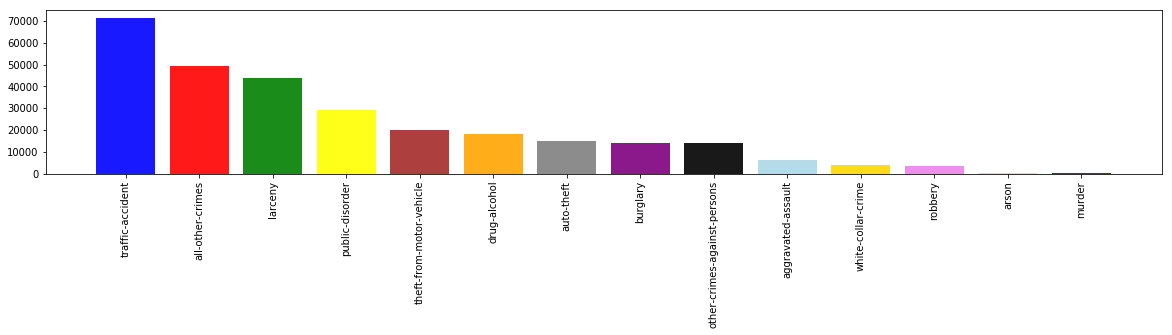

In [14]:
offense_counts = df_crimemerge_refined['OFFENSE_CATEGORY_ID'].value_counts(dropna=True, sort=True)
offense_counts.head()
df_offense = offense_counts.rename_axis('Offense Type').reset_index(name='counts')
df_offense['Offense Type'].count()

#plot graph
colors = ['blue', 'red', 'green', 'yellow', 'brown', 'orange', 'grey', 'purple', 'black', 'lightblue', 'gold', 'violet', 'pink', 'maroon']
# Creating our first plot: Count of offence type for all years
# plt.figure();

# offense_catgories.plot.hist()
# set categories as x-axis
x_axis = df_offense["Offense Type"]
# add tick mark for every offense type
tick_offense = [value for value in x_axis]

#plot graph
plt.figure(figsize=(20,3))
plt.bar(x_axis, df_offense['counts'], color=colors, alpha=0.9, align='center')
plt.xticks(tick_offense, df_offense['Offense Type'], rotation="vertical")
plt.savefig('NumberofOffensesbyCategory.png')

## Second Plot: Percentage of Number of Offenses by Category

(-1.1356569875605835,
 1.7302451687965457,
 -1.1024470981162837,
 1.1037729345417686)

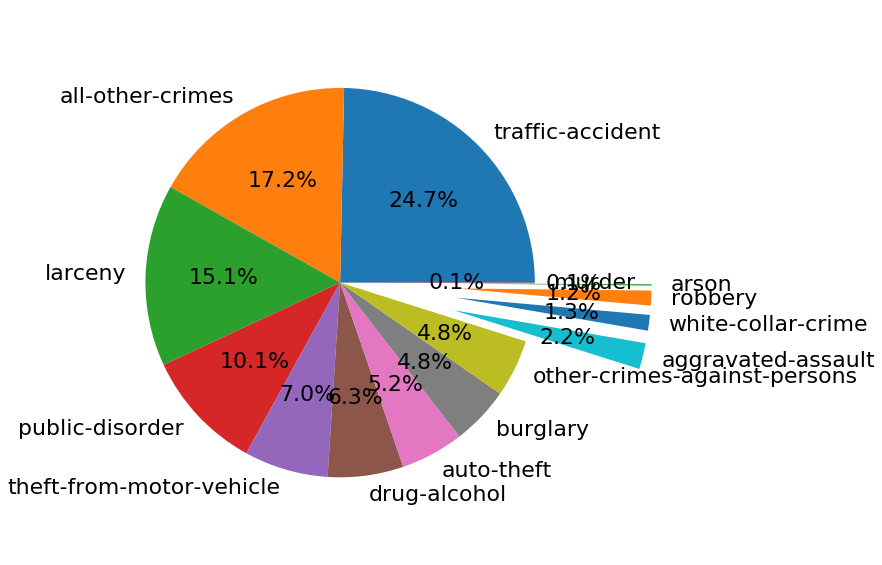

In [28]:
df_neighbor = offense_counts.rename_axis('Offense Types').reset_index(name='counts')
df_neighbor['Offense Types'].count()
# Labels for the sections of our pie chart
labels = df_neighbor["Offense Types"]

# The values of each section of the pie chart
sizes = df_neighbor["counts"]

# The colors of each section of the pie chart
colors = ["red", "orange", "lightcoral", "lightskyblue", "Purple"]

# Tells matplotlib to seperate the "Python" section from the others
explode = (0, 0, 0, 0,0,0, 0, 0, 0,0.6,0.6, 0.6, 0.6, 0)

# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=None,
       autopct="%1.1f%%", shadow=False, startangle=0)

rcParams['figure.figsize'] = 15, 15

# Tells matplotlib that we want a pie chart with equal axes
plt.axis("equal")
plt.savefig('PercentageofNumberofOffensesbyCategory.png')


## Third Plot: Crime Count per Time of Day

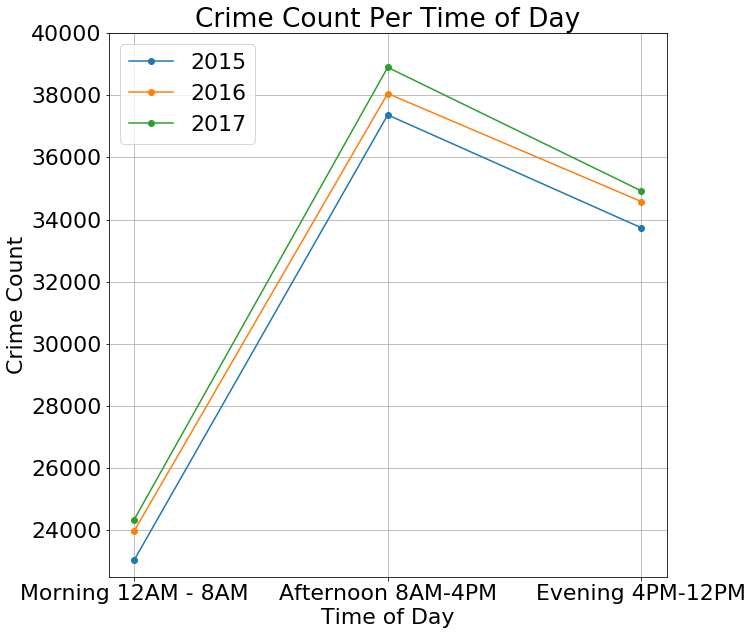

<Figure size 720x720 with 0 Axes>

In [31]:
#Year 2015
hour_2015 = df_15['FIRST_OCCURRENCE_DATE'].dt.hour
hour_2015_count = hour_2015.value_counts()
#Time of day for 2015
morning_2015 = hour_2015_count[0]+hour_2015_count[1]+hour_2015_count[2]+hour_2015_count[3]+hour_2015_count[4]+hour_2015_count[5]+hour_2015_count[6]+hour_2015_count[7]+hour_2015_count[8]
afternoon_2015 = hour_2015_count[9]+hour_2015_count[10]+hour_2015_count[11]+hour_2015_count[12]+hour_2015_count[13]+hour_2015_count[14]+hour_2015_count[15]+hour_2015_count[16]
evening_2015 = hour_2015_count[17]+hour_2015_count[18]+hour_2015_count[19]+hour_2015_count[20]+hour_2015_count[21]+hour_2015_count[22]+hour_2015_count[23]

#Year 2016
hour_2016 = df_16['FIRST_OCCURRENCE_DATE'].dt.hour
hour_2016_count = hour_2016.value_counts()
#Time of day for 2016
morning_2016 = hour_2016_count[0]+hour_2016_count[1]+hour_2016_count[2]+hour_2016_count[3]+hour_2016_count[4]+hour_2016_count[5]+hour_2016_count[6]+hour_2016_count[7]+hour_2016_count[8]
afternoon_2016 = hour_2016_count[9]+hour_2016_count[10]+hour_2016_count[11]+hour_2016_count[12]+hour_2016_count[13]+hour_2016_count[14]+hour_2016_count[15]+hour_2016_count[16]
evening_2016 = hour_2016_count[17]+hour_2016_count[18]+hour_2016_count[19]+hour_2016_count[20]+hour_2016_count[21]+hour_2016_count[22]+hour_2016_count[23]

#Year 2017
hour_2017 = df_17['FIRST_OCCURRENCE_DATE'].dt.hour
hour_2017_count = hour_2017.value_counts()
#Time of day for 2017
morning_2017 = hour_2017_count[0]+hour_2017_count[1]+hour_2017_count[2]+hour_2017_count[3]+hour_2017_count[4]+hour_2017_count[5]+hour_2017_count[6]+hour_2017_count[7]+hour_2017_count[8]
afternoon_2017 = hour_2017_count[9]+hour_2017_count[10]+hour_2017_count[11]+hour_2017_count[12]+hour_2017_count[13]+hour_2017_count[14]+hour_2017_count[15]+hour_2017_count[16]
evening_2017 = hour_2017_count[17]+hour_2017_count[18]+hour_2017_count[19]+hour_2017_count[20]+hour_2017_count[21]+hour_2017_count[22]+hour_2017_count[23]
#Created a dictionary of all data
Labels = ['2015 Morning', '2015 Afternoon','2015 Evening','2016 Morning', '2016 Afternoon','2016 Evening','2017 Morning', '2017 Afternoon','2017 Evening']
Times = [morning_2015, afternoon_2015, evening_2015,morning_2016, afternoon_2016, evening_2016,morning_2017, afternoon_2017, evening_2017]
hour_of_crime_dict = {'Time of Day':Labels, 'Crimes': Times}
hour_of_crime_df = pd.DataFrame(hour_of_crime_dict)
time_2015 = hour_of_crime_df.loc[0:2]
time_2016 = hour_of_crime_df.loc[3:5]
time_2017 = hour_of_crime_df.loc[6:8]
x_axis = ['Morning 12AM - 8AM','Afternoon 8AM-4PM', 'Evening 4PM-12PM']
matplotlib.rcParams.update({'font.size': 22})
plt.plot(x_axis,time_2015['Crimes'],marker='o')
plt.plot(x_axis,time_2016['Crimes'],marker='o')
plt.plot(x_axis,time_2017['Crimes'],marker='o')
plt.legend(['2015', '2016', '2017'])
plt.title('Crime Count Per Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Crime Count')
plt.ylim(22500,40000,2500)
rcParams['figure.figsize'] = 10, 10
plt.grid()
plt.show()
plt.savefig('CrimeCountPerTimeDay.png')

## Fourth Plot: Top 5 Crime Types over Years

In [21]:
df_15_top_5 = pd.DataFrame(df_15['OFFENSE_CATEGORY_ID'][0:5].value_counts())
df_16_top_5 = pd.DataFrame(df_16['OFFENSE_CATEGORY_ID'][0:5].value_counts())
df_17_top_5 = pd.DataFrame(df_17['OFFENSE_CATEGORY_ID'][0:5].value_counts())


In [22]:
#selecting top 5 crimes for 2015 
df_15_top_5 = pd.DataFrame(df_15['OFFENSE_CATEGORY_ID'].value_counts())
df_15_top_5 = df_15_top_5[0:5] 
print(df_15_top_5)

#selecting top 5 crimes for 2016 
df_16_top_5 = pd.DataFrame(df_16['OFFENSE_CATEGORY_ID'].value_counts())
df_16_top_5 = df_16_top_5[0:5] 
print(df_16_top_5)


#selecting top 5 crimes for 2017 
df_17_top_5 = pd.DataFrame(df_17['OFFENSE_CATEGORY_ID'].value_counts())
df_17_top_5 = df_17_top_5[0:5] 
print(df_17_top_5)

                          OFFENSE_CATEGORY_ID
traffic-accident                        23305
all-other-crimes                        15784
larceny                                 14161
public-disorder                          9791
theft-from-motor-vehicle                 6262
                          OFFENSE_CATEGORY_ID
traffic-accident                        23738
all-other-crimes                        16523
larceny                                 14842
public-disorder                          9914
theft-from-motor-vehicle                 6568
                          OFFENSE_CATEGORY_ID
traffic-accident                        24242
all-other-crimes                        17260
larceny                                 14649
public-disorder                          9344
theft-from-motor-vehicle                 7333


In [23]:
#Merger the top 5 crime data of 2015 and 2016 
df_1516_top_5 = pd.merge(df_15_top_5, df_16_top_5, left_index=True, right_index=True)

#Merger the top 5 crime data of 2015, 2016 and 2017
df_151617_top_5 = pd.merge(df_1516_top_5, df_17_top_5, left_index=True, right_index=True)


In [24]:
#Selecting values over years for each crime type
y1 = [23305, 23738, 24242]
y2 = [15784, 15784, 17260]
y3 = [14161, 14161, 14649]
y4 = [9791, 9914, 9344]
y5 = [6262, 6568, 7333]

x = np.arange(len(y1))



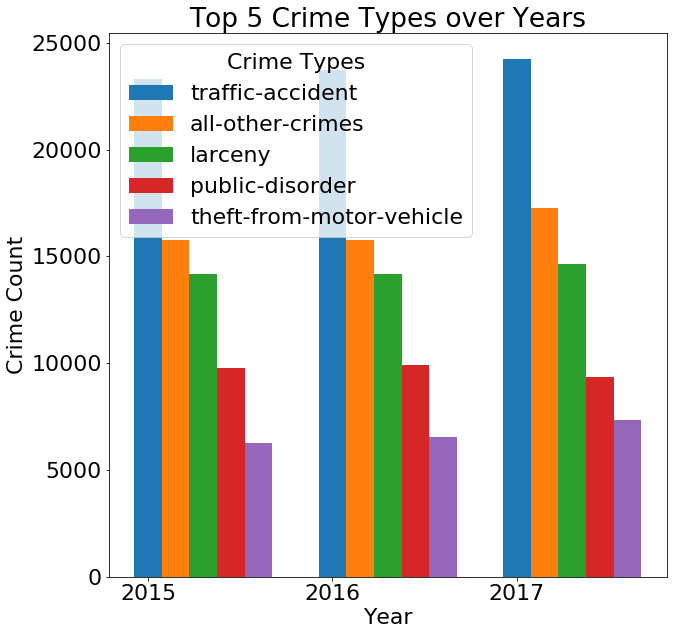

In [32]:
#Plot data with multiple bar graphs side by side 

bar_width = 0.15
plt.bar(x, y1, width = bar_width)
plt.bar(x + bar_width , y2, width = bar_width)
plt.bar(x + bar_width*2, y3, width = bar_width)
plt.bar(x + bar_width*3, y4, width = bar_width)
plt.bar(x + bar_width*4, y5, width = bar_width)
plt.xticks(np.arange(3), ('2015', '2016', '2017'))
plt.legend(['traffic-accident', 'all-other-crimes', 'larceny', 'public-disorder', 'theft-from-motor-vehicle'], title = 'Crime Types')
plt.xlabel ('Year')
plt.ylabel ('Crime Count')
plt.title('Top 5 Crime Types over Years')
rcParams['figure.figsize'] = 10, 10
plt.show()
plt.savefig('Top5CrimeTypesoverYears.png')

## Fifth Plot: Crime Location Heat Map

In [33]:
#Groupby the mean of each neighborhood 
df_neighborhood_mean = df_crimemerge_refined.groupby('NEIGHBORHOOD_ID').mean()
df_neighborhood_mean

#Groupby the count of each neighborhood
df_neighborhood_crime_count = df_crimemerge_refined.groupby('NEIGHBORHOOD_ID').count()
df_neighborhood_crime_count

#Merge two dataframes together 
df_neighborhood = pd.merge(df_neighborhood_mean, df_neighborhood_crime_count, on = 'NEIGHBORHOOD_ID', how = 'outer')

#only select 3 columns 
df_neighborhood = df_neighborhood[['GEO_LAT_x', 'GEO_LON_x', 'INCIDENT_ID_y']]
df_neighborhood.head()

,GEO_LAT_x,GEO_LON_x,INCIDENT_ID_y
NEIGHBORHOOD_ID,,,
athmar-park,39.705324,-105.014568,4138
auraria,39.745441,-105.006189,3079
baker,39.715903,-104.996173,7803
barnum,39.719350,-105.030218,3639
barnum-west,39.719710,-105.047421,1917


In [40]:
#Finding Location Point Map 
locations = df_neighborhood[["GEO_LAT_x", "GEO_LON_x"]].astype(float)
markers = gmaps.marker_layer(locations)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))

In [37]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [38]:
# Store 'Lat' and 'Lng' into  locations 
locations = df_neighborhood[["GEO_LAT_x", "GEO_LON_x"]].astype(float)

# Convert crime rate to float and store
# HINT: be sure to handle NaN values
crime_rate = df_neighborhood["INCIDENT_ID_y"].astype(int)


In [39]:
# Create a poverty Heatmap layer
fig = gmaps.figure(map_type = 'HYBRID')

heat_layer = gmaps.heatmap_layer(locations, weights = crime_rate,
                                 dissipating=True, max_intensity=2000,
                                 point_radius = 20)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = True
heat_layer.max_intensity = 2000
heat_layer.point_radius = 20

fig.add_layer(heat_layer)

fig
plt.savefig('CrimeLocationHeatMap.png')

Figure(layout=FigureLayout(height='420px'))